<a href="https://colab.research.google.com/github/haryobimo96/k-means-algorithm/blob/main/K_Means_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What is K-Means?**

K-Means is a clustering algorithm used for determining clusters of sets of data by determining their cluster centers. It is a type of unsupervised learning that does not rely on labelling. The way K-means decides a cluster center is by calculating the mean of feature vectors for each cluster of data. This new means will shift the previous cluster centers to a new set points that minimizes each cluster variance. 

To give you a clearer example, let's dive straight to an example using Iris Dataset.

In [1]:
from sklearn.datasets import load_iris
data = load_iris()

We only need the array of the data which we can call by executing:

In [20]:
# Load the array containing variables
data_array = data.data

# Print the first 5 examples of data
print(data_array[0:5])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


We only need the array, but what do the numbers mean? For each column of the array, each represents an independent variable that might be used to determine the species of a given Iris flower and each row of the array represents a different data point. To give you a clearer example, let's convert the data into pandas dataframe.

In [21]:
import pandas as pd
import numpy as np

df = pd.DataFrame(
    {'sepal_length': data.data[:,0],
     'sepal_width': data.data[:,1],
     'petal_length': data.data[:,2],
     'petal_width': data.data[:,3],
     'species': data.target_names[data.target]})

df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We can express each data point as a $D$-dimensional feature vector where $D$ equals to the number of independent variables describing the data. So for example, for the first data, we will have a feature vector of:

$\mathbf{{x_1}} = [5.1, 3.5, 1.4, 0.2]$

The second one:

$\mathbf{{x_2}} = [4.9, 3.0, 1.4, 0.2]$

and so on

Let's take a look on the distribution of each data point using a scatter plot.

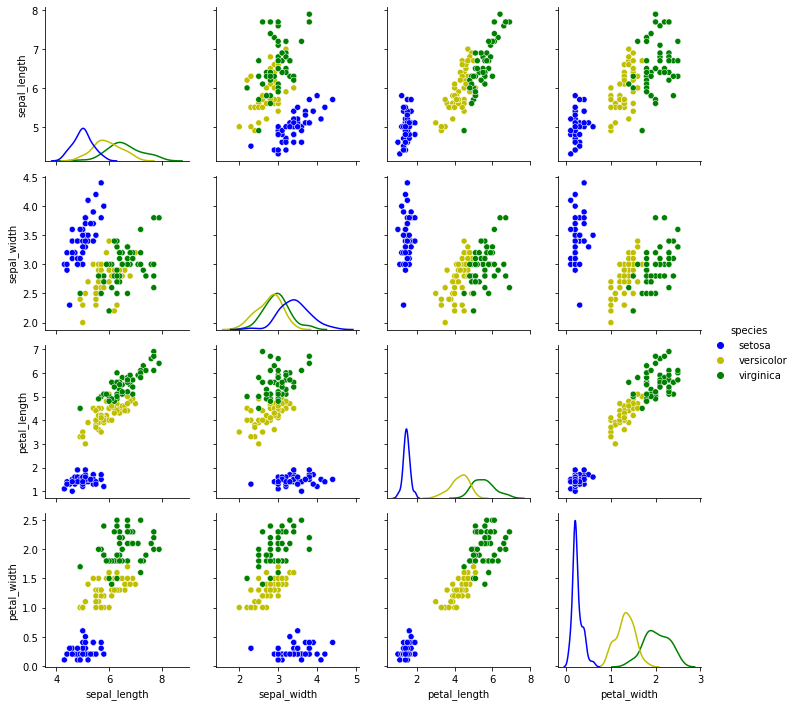

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.PairGrid(df, hue="species",
                 hue_order = ["setosa", "versicolor", "virginica"],
                 palette = ["b", "y", "g"])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

This is how the data points are distributed along four independent variables. Qualitatively, you can already separate (cluster) each different species from the colours. Let's save this graph for later.

Let's jump into the algorithm. The first thing we need to do is to initialize random mean vectors for each cluster. We can do so by using this randomization function which takes data from a pandas dataframe and converts it to initial vectors that represent centers of data clusters. Since we have 3 clusters of data, we will initialize only 3 initial mean vectors

In [23]:
import numpy as np

class RandomInitialization():
    def __init__(self, df: pd.DataFrame):
        # Load the dataframe columns containing the numerical 
        # variables
        self.df = df.select_dtypes(include='number')
        self.variable_list = list(self.df.columns.values)

    def __randomized_value(self, column_name: str) -> float:
        # Let's set the random uniformly-distributed vectors to be within 
        # the data range.
        return np.random.uniform(
            low = min(self.df[column_name]),
            high = max(self.df[column_name])
        )

    def __call__(self, k: int) -> np.array:
        # Return a set of randomized initial mean vectors
        randomized_val_k = []
        for i in range(k):
            # Set random seed to ensure reproducibility
            np.random.seed(42+i)
            randomized_val_list = []
            for variables in self.variable_list:
                randomized_val_list.append(
                    self.__randomized_value(column_name = variables)
                )
            randomized_val_k.append(randomized_val_list)
        return np.array(randomized_val_k)

The initial set of mean vectors {$\mathbf{\mu_1}, \mathbf{\mu_2}, \mathbf{\mu_3}$} will be:

In [24]:
initializer = RandomInitialization(df)
random_init_vector = initializer(k=3).round(decimals=2)
print(random_init_vector)

[[5.65 4.28 5.32 1.54]
 [4.71 3.46 1.79 0.68]
 [7.31 2.25 5.39 0.97]]


Here, we set $\mathbf{\mu_1} = [5.65,4.28,5.32,1.54]$, $\mathbf{\mu_2} = [4.71,3.46,1.79,0.68]$.

Let's take a look of how our mean vectors are placed in our data points.

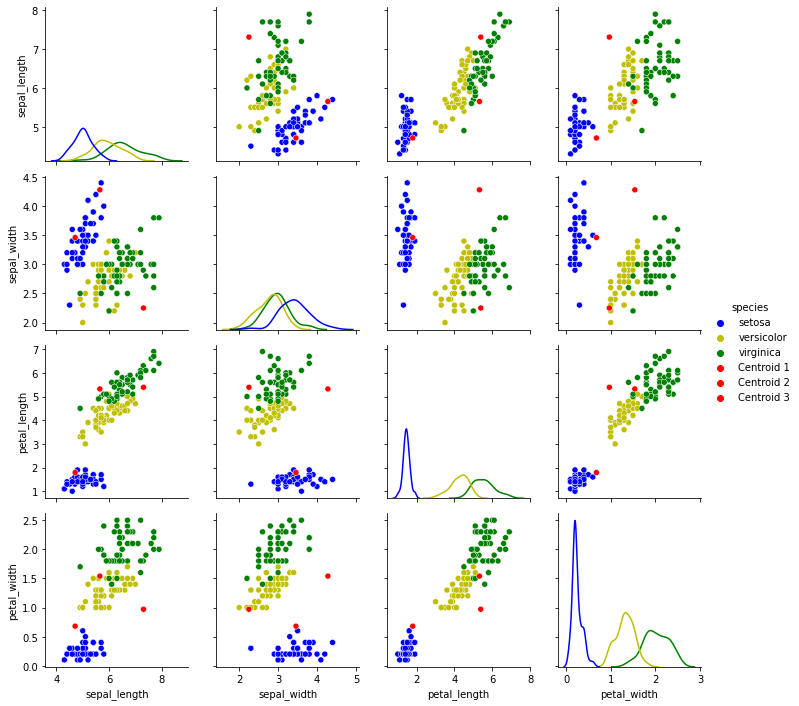

In [25]:
import warnings
warnings.filterwarnings('ignore')
centroids = pd.DataFrame(random_init_vector, columns = ['sepal_length',
                                                        'sepal_width',
                                                        'petal_length',
                                                        'petal_width'])

centroids["species"] = ["Centroid 1", 'Centroid 2', 'Centroid 3']
full_ds = pd.concat([df, centroids], ignore_index=True)

g = sns.PairGrid(full_ds, hue="species",
                 hue_order = ["setosa", "versicolor", "virginica", 
                              "Centroid 1", "Centroid 2", "Centroid 3"],
                 palette = ["b", "y", "g", "r", "r", "r"])

g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

As you can see, our set of mean vectors does not describe each cluster well as the cluster centers are way off.

Where we remember that each column represents different variables (the first one sepal length, the second sepal width, and so on) and each row represents different clusters. Now, we need to calculate each data point distance to our initial set of mean vectors {$\mu_1, \mu_2, \mu_3$}. We can do so by using Euclidean L2-distance as a Dissimilarity Measure between each data point and the assigned cluster centers, where:


\begin{align}
    d(\mathbf{x_n},\mathbf{x_{n'}}) = \sum_{j=1}^D (\mathbf{x_{n}}-\mathbf{x_{n'j}})^2 = ||\mathbf{x_n} - \mathbf{x_{n'}}||^2 \tag{1}
\end{align}

Or, for the specific case of using mean vectors:

\begin{align}
    d(\mathbf{x_n},\mathbf{\mu_k}) = ||\mathbf{x_n} - \mathbf{\mu_k}||^2 \tag{2}
\end{align}

Where $n$ represents data indices (rows), $j$ represents columns (representing different variables), and $k$ represents $k$-th cluster. As there are multiple clusters, we must take into account every distance of each data point to each mean vector. For example, let's say we have $\mathbf{x_1} = [5.1, 3.5, 1.4, 0.2]$ as one of our data. We need to calculate each of the distance by ```random_init_vector``` as our initial mean vectors.


In [26]:
first_data = df.select_dtypes(include='number').iloc[0]
first_data = first_data.values
print(first_data)

[5.1 3.5 1.4 0.2]


In [27]:
for i in range(len(random_init_vector)):
    distance = first_data - random_init_vector[i]
    print(distance.dot(distance.transpose()).round(decimals=2))

18.07
0.54
22.96


Which means that $d(\mathbf{x_1}, \mathbf{\mu_1}) = 18.07$, $d(\mathbf{x_1}, \mathbf{\mu_2})= 0.54$, and $d(\mathbf{x_1}, \mathbf{\mu_3}) = 22.96$ 

As you can see, our first data point $x_1$ has the least distance to the second initial mean vector, $\mathbf{\mu_2} = [4.71, 3.46, 1.79, 0.68]$, which means that initially, data point $\mathbf{x_1}$ belongs to a cluster with a mean vector of $\mathbf{\mu_2}$ or $\textrm{argmin}_j||\mathbf{x_n} - \mathbf{\mu_k}||^2 = (k = 2)$. From this definition of clustering (based on the shortest distance), we can define our objective function as: 

\begin{align}
    J = \sum_{n=1}^N \sum_{k=1}^K r_{nk}||\mathbf{x_n} - \mathbf{\mu_k}||^2 \tag{3}
\end{align}

Where $r_{nk}$ is defined as:

\begin{align}
r_{nk} = \left\{
\begin{array}{cl}
1, & \textrm{if}\ k = \textrm{argmin}_j ||\mathbf{x_n} - \mathbf{\mu_j}||^2\\
0, & \textrm{otherwise}
\end{array}
\tag{4}
\right.
\end{align}

Which means that our objective function $J$ only measures the distance to the nearest mean vector.

Let us define an ```EuclideanMeasure``` class that takes into account every data point available and every mean vector there.

In [28]:
class EuclideanMeasure():
    def __init__(self,
                 data_point: np.array,
                 mean_array: np.array):
        self.data_point = data_point
        self.mean_array = mean_array

    def __euclidean_distance(self,
                           data_point: np.array,
                           mean_vector: np.array) -> np.array:
        # Calculate L2 distance of each data spontaneously
        mean_vector = mean_vector.reshape((mean_vector.shape[0],))
        subtracted_array = data_point - mean_vector
        distance_array = np.diagonal(
            subtracted_array.dot(subtracted_array.transpose())
        )
        return distance_array

    def Array(self) -> np.array:
        # Calculate all euclidean distances for every cluster available
        k = len(self.mean_array)
        shape_tuple = (k, self.data_point.shape[0])
        distance_arrays = np.zeros(shape_tuple)

        for i in range(len(self.mean_array)):
            distance = self.__euclidean_distance(
                self.data_point, self.mean_array[i])
            distance_arrays[i] = distance

        return distance_arrays

Let's test it out

In [29]:
data_point = df.select_dtypes(include='number').values
em = EuclideanMeasure(data_point, random_init_vector)
distance_arrays = em.Array()

```distance_arrays[k]``` will now return the Euclidean distance for every data relative to $k$-th mean vector. Let's see the result for each $k$-th iteration of $(\mathbf{x_1} - \mathbf{\mu_k})$

In [30]:
for k in range(3):
    print(distance_arrays[k][0].round(decimals=2))

18.07
0.54
22.96


Or, for all distance data relative to the 3rd mean vector ($k=3$):

In [31]:
print(distance_arrays[2].round(decimals=2))

[22.96 22.88 25.04 23.79 23.67 20.31 25.04 22.38 25.4  22.42 21.48 22.58
 23.54 28.78 23.49 22.67 23.42 22.82 19.06 22.87 19.18 22.44 29.03 19.82
 20.4  20.86 21.35 21.74 22.29 22.67 21.98 20.43 23.76 23.59 22.26 24.39
 22.16 24.31 26.35 21.93 24.08 25.08 26.69 21.4  19.79 23.23 22.24 24.76
 21.87 22.95  1.66  2.8   1.41  5.32  1.86  3.8   3.   10.2   1.66  7.06
  8.97  4.25  3.65  2.55  6.66  2.26  4.56  4.15  2.31  5.22  3.93  3.81
  1.6   2.3   2.55  2.23  1.1   1.62  3.21  6.29  5.84  6.16  4.76  2.4
  5.28  4.23  1.85  2.11  5.26  5.38  4.43  2.84  4.39  9.71  4.65  4.62
  4.54  2.95 10.68  4.67  4.84  3.43  2.14  2.18  2.9   3.39  7.2   1.94
  1.29  4.68  2.7   1.9   2.11  3.87  4.71  3.51  1.92  5.78  4.32  2.15
  2.94  4.53  3.23  2.15  2.85  1.98  2.57  2.96  2.45  1.14  1.68  4.83
  2.69  1.69  1.82  2.99  4.43  2.25  3.32  2.17  3.18  2.74  3.43  3.19
  3.91  2.74  2.1   2.32  4.32  3.32]


Now, to get our $r_{nk}$, we simply select the minimum value among every cluster and 0 otherwise. We can do this by:

In [32]:
# This will return the indices with lowest distance value
minimum_indices = np.argmin(distance_arrays, axis=0)
# This will return 1 for k-th cluster if it's the argmin. This is basically
# our implementation of Equation (4)
cluster_assignment = np.zeros(distance_arrays.shape)
for i in range(distance_arrays.shape[1]):
    idx = minimum_indices[i]
    cluster_assignment[idx,i] = 1

We can now check our cluster assignment for every possible cluster

In [33]:
print(cluster_assignment)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1.
  1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0.
  1. 0. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

We can calculate the objective function by multiplying our cluster assignment with our distance array and summing every component of the result as the implication of Equation (3) and (4) indicates that we can ignore any non-minimum distance to a mean vector.

In [34]:
distance_by_cluster =  cluster_assignment * distance_arrays
objective_function = np.sum(distance_by_cluster)
print(objective_function.round(decimals=2))

320.08


This is our initial value of $J$. If you remember that our initial vectors are still out-of-place from the actual center of the clusters, we'll see that this objective function value is not yet minimum and we need to optimize it. We need to set Equation (3)'s derivative with respect to $\mu_k$ to 0, or

\begin{align}
    \frac{\partial{J}}{\partial{\mathbf{\mu_k}}} = \frac{\partial}{\partial{\mathbf{\mu_k}}}\sum_{n=1}^N \sum_{k=1}^K r_{nk}||\mathbf{x_n} - \mathbf{\mu_k}||^2 \tag{5}
\end{align}

resulting in,

\begin{align}
    - 2\sum_{n=1}^N r_{nk}(\mathbf{x_n} - \mathbf{\mu_k}) = 0 \tag{6}
\end{align}

with out updated mean vector (for each cluster) to minimize the objective function rewritten as:

\begin{align}
    \mathbf{\mu_k} = \frac{\sum_n\ r_{nk} \mathbf{x_n}}{\sum_n r_{nk}} \tag{7}
\end{align}

This updated $\mathbf{\mu_k}$ will replace our initial mean vectors from the beginning. Thus, the training iteration process is done.




Let's calculate our updated mean vectors using Equation (7). We use ```cluster_assignment``` from before as our $r_{nk}$ and ```data_array``` as our set of data $\mathbf{x}$. Let's also calculate the objective function for every epoch where we set our epoch to be 7. From our array manipulation from before, we can define ```ClusterMethod``` to iterate our k-means algorithm (with objective function and cluster decision included) to decide which cluster a data point belongs to

In [42]:
class ClusterMethod(EuclideanMeasure):
    def __init__(self,
                 data_point: np.array,
                 mean_array: np.array):
        super().__init__(data_point, mean_array)

    def _cluster_assignment(self, array: np.array) -> float:
        # Calculate the lowest distance value relative to each
        # component of mean vectors set and assign each data point
        # as part of a cluster centered on the nearest mean vector
        minimum_indices = np.argmin(array, axis=0)
        cluster_assignment = np.zeros(array.shape)
        for i in range(array.shape[1]):
            idx = minimum_indices[i]
            cluster_assignment[idx,i] = 1
        distance_by_cluster = cluster_assignment * array
        return cluster_assignment, distance_by_cluster
    
    def _objective_function(self,
                            data_point: np.array,
                            mean_array: np.array) -> float:
        # Calculate the objective function J
        distance_arrays = self.Array()
        __, distance_by_cluster = self._cluster_assignment(distance_arrays)
        objective_function = np.sum(distance_by_cluster)
        return objective_function.round(decimals=2)
    
    def __call__(self, epoch: int) -> float:
        # Iterate and optimize the objective function
        cluster_assignment, __ = self._cluster_assignment(self.Array())
        template = np.zeros((
            (len(cluster_assignment),) + self.data_point.shape))
        divisor = np.zeros((len(cluster_assignment),1))

        iter_num = 0
        while iter_num < epoch:
            if iter_num == 0:
                mean_array = self.mean_array
                cluster_assignment, __ = self._cluster_assignment(self.Array())
            else:
                self.mean_array = mean_array
                cluster_assignment, __ = self._cluster_assignment(self.Array())
            
            # This part of code implements the calculation of Equation (7) ===
            for i in range(template.shape[0]):
                for j in range(template.shape[1]):
                    template[i][j] = cluster_assignment[i][j] * self.data_point[j]
                divisor[i] =  np.sum(cluster_assignment[i])
            mean_array = np.sum(template, axis = 1)
            mean_array = mean_array/divisor

            # Calculate the objective function
            print('Objective function value: {} (Epoch: {}/{})'.format(
                self._objective_function(self.data_point, mean_array),
                iter_num+1, epoch))
            iter_num = iter_num + 1
        
        return mean_array

In [43]:
cm = ClusterMethod(data_point, random_init_vector)
mean_array = cm(epoch=7)
print(mean_array.round(decimals=2))

Objective function value: 320.08 (Epoch: 1/7)
Objective function value: 118.37 (Epoch: 2/7)
Objective function value: 81.28 (Epoch: 3/7)
Objective function value: 79.58 (Epoch: 4/7)
Objective function value: 79.0 (Epoch: 5/7)
Objective function value: 78.86 (Epoch: 6/7)
Objective function value: 78.86 (Epoch: 7/7)
[[5.88 2.74 4.39 1.43]
 [5.01 3.43 1.46 0.25]
 [6.85 3.08 5.72 2.05]]


This is our new set of mean vectors that converges to an objective function value of 78.86. Let's visualize the position of each mean vector in the vector spaces.

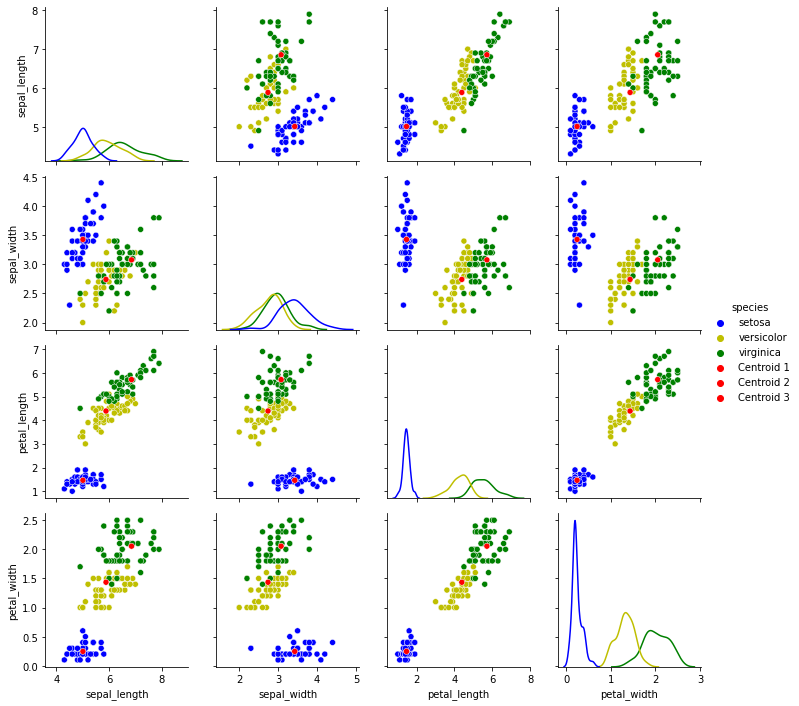

In [44]:
import warnings
warnings.filterwarnings('ignore')
centroids = pd.DataFrame(mean_array, columns = ['sepal_length',
                                                'sepal_width',
                                                'petal_length',
                                                'petal_width'])

centroids["species"] = ["Centroid 1", 'Centroid 2', 'Centroid 3']
full_ds = pd.concat([df, centroids], ignore_index=True)

g = sns.PairGrid(full_ds, hue="species",
                 hue_order = ["setosa", "versicolor", "virginica", 
                              "Centroid 1", "Centroid 2", "Centroid 3"],
                 palette = ["b", "y", "g", "r", "r", "r"])

g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

As you can see, the mean vectors are now closer to each cluster center than before. For summary on what's going on, here's what the algorithm does:

1.   Initialize set of $K$-amounts of random mean vectors $\mathbf{\mu}  =$ {$\mathbf{\mu_1}$, $\mathbf{\mu_2}$, $...$, $\mathbf{\mu_K}$}
2.   Measure the distance for each data point $\mathbf{x} =$  {$\mathbf{x_1}$, $\mathbf{x_2}$, $...$, $\mathbf{x_N}$} relative to each initialized mean vector ($||\mathbf{x_n} - \mathbf{\mu_k}||^2$)
3.   Calculate the objective function $ J = \sum_{n=1}^N \sum_{k=1}^K r_{nk}||\mathbf{x_n} - \mathbf{\mu_k}||^2$ where we choose the shortest distance to each mean vector by using $r_{nk}$ factor
4.   Update our new set of mean vectors $\mathbf{\mu_k} = \frac{\sum_n\ r_{nk} \mathbf{x_n}}{\sum_n r_{nk}}$ for $1\leq k \leq K$
5.   Repeat Step 1 but with our newly generated set of mean vectors

References:

1.   Bishop, C. M. (2006). Pattern Recognition and Machine Learning. New York, Springer. 
2.   Hastie, T., Tibshirani, R., and Friedman, J. (2008). Elements of Statistical Learning. California, Springer.

